In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [20]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

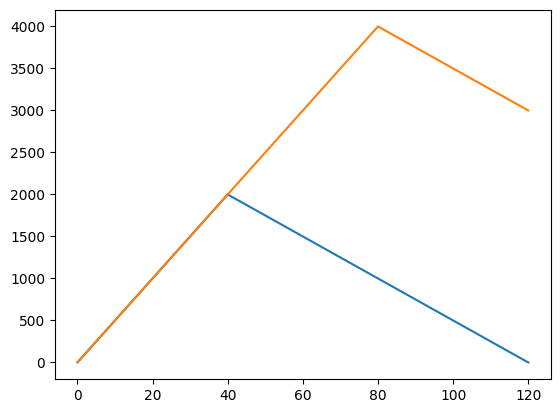

In [26]:
I = 2.
rho_i = jnp.linspace(0, rho_max, 100)
plt.plot(rho_i, Q_e(rho_i))
plt.plot(rho_i, I*Q_e(rho_i/I))

In [62]:
x_0, x_N = 0, 100
N_x = 101
T_sim = 4
N_t = 5000

dx = (x_N - x_0)/(N_x-1)
dt = T_sim/N_t

xs = jnp.linspace(x_0, x_N, N_x)
rho_0x = rho_max/4 + jnp.exp(-jnp.square((xs - x_N/2)/20))*rho_max/2
rho_t0 = rho_max/4 + jnp.zeros(N_t) 
rho_t1 = rho_max/4 + jnp.zeros(N_t) 

In [63]:
@jax.jit
def g_godunov(u, v, I): 
    I_u = I[:-1]
    I_v = I[1:]
    mi = jnp.minimum(I_u*Q_e(u/I_u), I_v*Q_e(v/I_v))
    ma = jnp.maximum(I_u*Q_e(u/I_u), I_v*Q_e(v/I_v))
    return jnp.where(u<=v, mi, ma)

In [76]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1
I = np.ones(N_x)
I[90] = 0.9

for t_i in range(N_t-1):
    f_left = g_godunov(rho[t_i, :-2], rho[t_i, 1:-1], I[:-1])
    f_right = g_godunov(rho[t_i, 1:-1], rho[t_i, 2:], I[1:])
    rho[t_i+1, 1:-1] = rho[t_i, 1:-1] - dt/dx*(f_right - f_left)

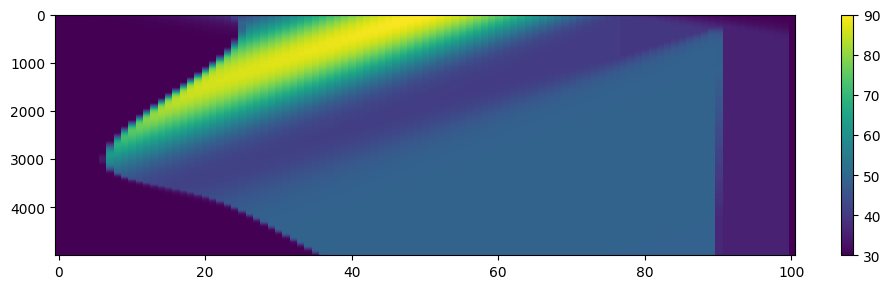

In [77]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()